In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
FIGURE_WIDTH = 16
ROW_HEIGHT = 3
RESIZE_DIMENSION = 28

In [3]:
project_dir= os.getcwd()
print(project_dir)

/media/arfan/Study & Softwares/1. STUDY/1. Deep Learning/BanglaDigits/numta


In [4]:
paths_train_a=glob.glob(os.path.join(project_dir,'training-a','*.png'))
path_label_train_a=os.path.join(project_dir,'training-a.csv')

In [5]:
def get_label(path):
    key=path.split(sep=os.sep)[-1]
    return key

In [6]:
def get_data(image_path,path_label,resize_dimension=None,rescale=True):
    X=[]
    for i,path in enumerate(image_path):
        image=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # read image, image size is 180x180
        if resize_dimension!=None:
            image=cv2.resize(image,(resize_dimension,resize_dimension),interpolation=cv2.INTER_AREA) # resize image to 28x28
        if rescale==True:
            image=image/255
        X.append(np.expand_dims(image,axis=2))
        if i==len(image_path)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(image_path)),end=end)
        
    X=np.array(X)
    data_frame = pd.read_csv(path_label)
    data_frame=data_frame.set_index('filename') 
    y_label=[data_frame.loc[get_label(path)]['digit'] for path in  image_path]
    y=to_categorical(y_label,10)
    return X, y

def imshow_batch(X,y=None,y_pred=None,image_per_row=10,phase='processed'):
    sample_number=len(X)
    image_dimension=X.shape[1]
    j=np.ceil(sample_number/image_per_row)
    figure=plt.figure(figsize=(FIGURE_WIDTH,4*j))
    for i,image in enumerate(X):
        plt.subplot(j,image_per_row,i+1)
        image_sq=np.squeeze(image,axis=2)
        plt.imshow(image_sq,cmap='gray')
        if y is not None:
            plt.title(np.argmax(y[i]))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=image_dimension+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(image_dimension/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()

In [7]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dimension = RESIZE_DIMENSION)

processed 19702/19702


In [8]:
X_sample = X_train_a[:40]
y_sample = y_train_a[:40]

In [9]:
X_sample.shape

(40, 28, 28, 1)

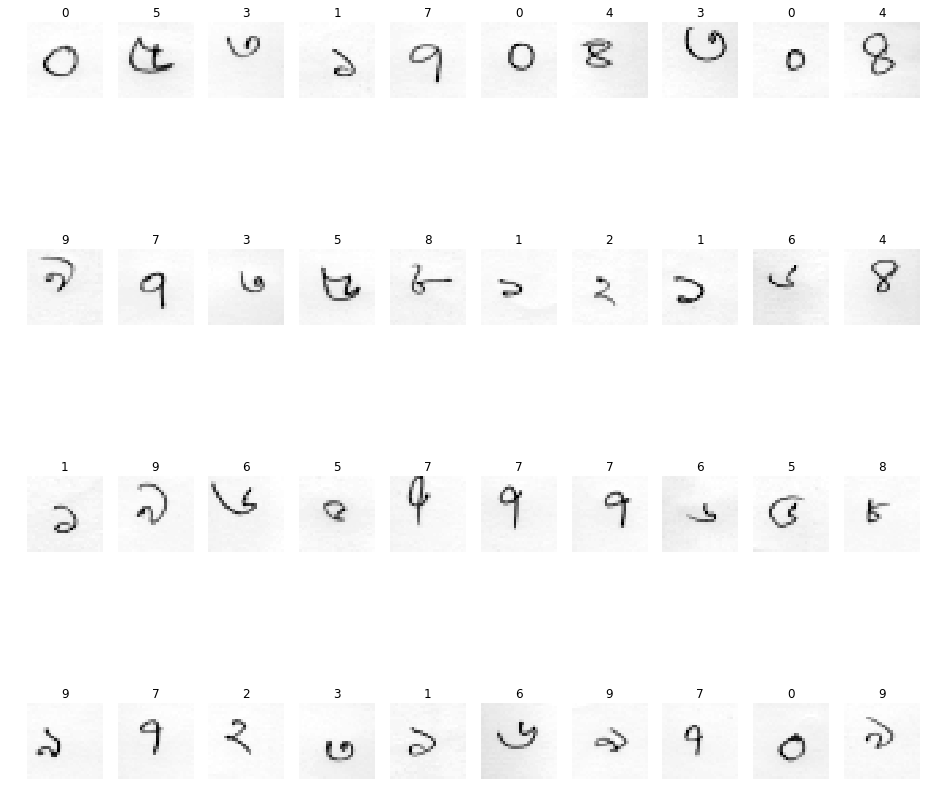

In [10]:
imshow_batch(X = X_sample, y = y_sample)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state=42)

In [12]:
model = RandomForestClassifier(n_jobs = -1, n_estimators = 500)

In [13]:
sample_no, x_number, y_number, channel = X_train.shape
print(sample_no, x_number, y_number, channel)
X_train_reshaped= X_train.reshape((sample_no, x_number * y_number))

14776 28 28 1


In [14]:
model.fit(X_train_reshaped, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
sample_no_test, x_number_test, y_number_test, channel_test = X_test.shape
X_test_reshaped= X_test.reshape((sample_no_test, x_number_test * y_number_test))
model.score(X_test_reshaped, y_test)

0.546285018270402

In [16]:
predictions = model.predict(X_test_reshaped)

In [17]:
correct_indices=[]
for i,pred in enumerate(predictions):
    if np.argmax(y_test[i])==np.argmax(pred):
        correct_indices.append(i)

In [18]:
X_c=X_test[correct_indices[:40]]
y_c=predictions[correct_indices[:40]]
y_true=y_test[correct_indices[:40]]

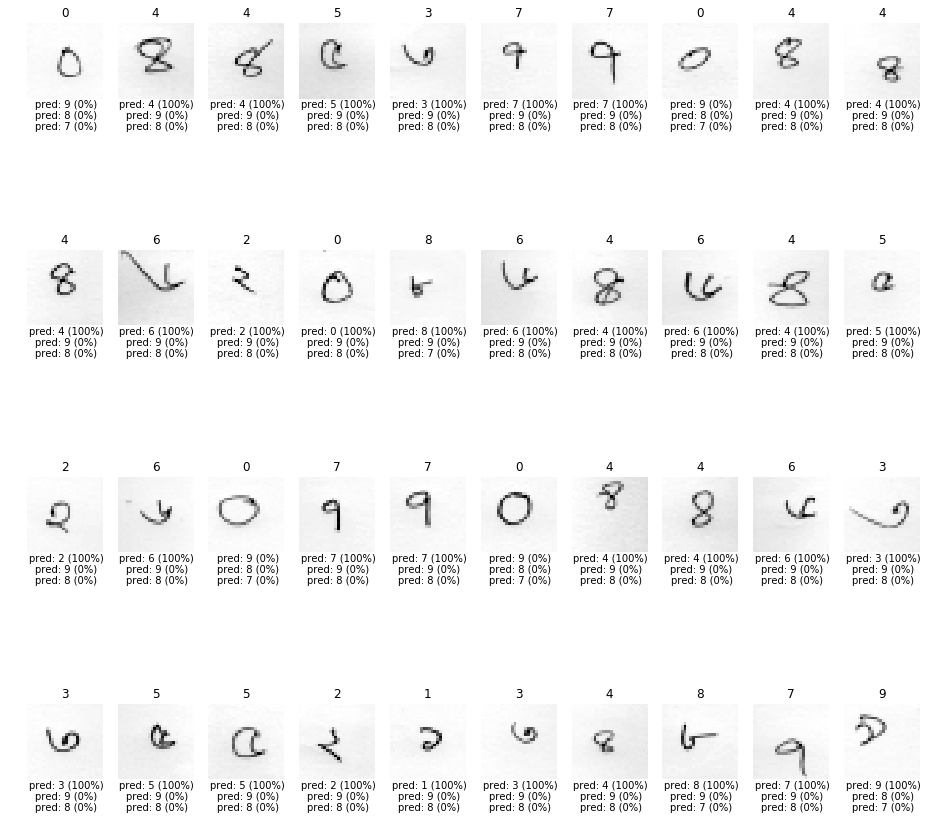

In [19]:
imshow_batch(X=X_c,y=y_true,y_pred=y_c)